In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.ensemble import RandomForestRegressor
import datetime
from boruta import BorutaPy
from sklearn.metrics import mean_squared_error
import shap
from tensorflow import keras
import tensorflow as tf

In [3]:
%load_ext nb_black
%matplotlib inline

<IPython.core.display.Javascript object>

In [4]:
train = catalog.load("train_contract_value")
cv = catalog.load("cv_contract_value")
test = catalog.load("test_contract_value")

[08/14/22 21:33:28] INFO     Loading data from 'train_contract_value' (ParquetDataSet)...       ]8;id=734648;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=695332;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

[08/14/22 21:33:33] INFO     Loading data from 'cv_contract_value' (ParquetDataSet)...          ]8;id=520430;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=948440;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'test_contract_value' (ParquetDataSet)...        ]8;id=310888;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=795006;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

<IPython.core.display.Javascript object>

In [5]:
y_train = train["log_valor_del_contrato"].values
y_cv = cv["log_valor_del_contrato"].values
y_test = test["log_valor_del_contrato"].values

<IPython.core.display.Javascript object>

In [6]:
train.drop(["log_valor_del_contrato", "index"], axis=1, inplace=True)
cv.drop(["log_valor_del_contrato", "index"], axis=1, inplace=True)
test.drop(["log_valor_del_contrato", "index"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [7]:
def gen_rf_hyperparameters():
    n_estimators = max(int(10 ** (np.random.random() * 1.5 + 1)), 1)
    max_depth = np.random.choice([2, 5, 7, 10, 15, 20])
    min_samples_leaf = np.random.randint(1, 100)
    max_features = np.random.random()
    return {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_leaf": min_samples_leaf,
        "max_features": max_features,
    }

<IPython.core.display.Javascript object>

In [8]:
xn_cv = 15
score = np.inf
final_params = None
for i in range(n_cv):
    if i % 2 == 0:
        print(
            f"Iteration {i+1} - {n_cv}: CV - {datetime.datetime.today().strftime('%H:%M:%S')}"
        )
    params = gen_rf_hyperparameters()
    model = RandomForestRegressor(**params)
    model.fit(train, y_train)
    pred = model.predict(cv)
    cv_score = mean_squared_error(y_cv, pred) ** 0.5
    if cv_score < score:
        score = cv_score
        final_params = params
    print(f"Iteration {i+1} - RMSE :{cv_score}")

Iteration 1 - 15: CV - 16:12:14
Iteration 1 - RMSE :0.9746217383885054
Iteration 2 - RMSE :0.9416737146608866
Iteration 3 - 15: CV - 16:48:45
Iteration 3 - RMSE :1.3284620083348861
Iteration 4 - RMSE :1.1689281964437488
Iteration 5 - 15: CV - 16:50:31
Iteration 5 - RMSE :0.9709298880135664
Iteration 6 - RMSE :0.943415727446579
Iteration 7 - 15: CV - 16:55:28
Iteration 7 - RMSE :1.276198734914523
Iteration 8 - RMSE :1.1725846201431211
Iteration 9 - 15: CV - 16:56:01
Iteration 9 - RMSE :0.9478364571604433
Iteration 10 - RMSE :0.9475336320378565
Iteration 11 - 15: CV - 17:20:34
Iteration 11 - RMSE :0.9665313830287949
Iteration 12 - RMSE :1.0056847393908643
Iteration 13 - 15: CV - 17:24:26
Iteration 13 - RMSE :0.9833955531999348
Iteration 14 - RMSE :0.940890443906045
Iteration 15 - 15: CV - 18:14:48
Iteration 15 - RMSE :0.9492668091049051


<IPython.core.display.Javascript object>

In [12]:
# final_params = {
#    "n_estimators": 78,
#    "max_depth": 20,
#    "min_samples_leaf": 77,
#    "max_features": 0.8530949098629828,
# }

<IPython.core.display.Javascript object>

In [13]:
model = RandomForestRegressor(**final_params)
model.fit(train, y_train)

RandomForestRegressor(max_depth=20, max_features=0.8530949098629828,
                      min_samples_leaf=77, n_estimators=78)

<IPython.core.display.Javascript object>

In [14]:
pred_test = model.predict(test)

<IPython.core.display.Javascript object>

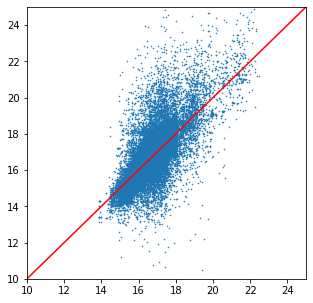

<IPython.core.display.Javascript object>

In [34]:
fig, ax = plt.subplots()
ax.scatter(x=pred_test, y=y_test, s=0.3)
ax.plot([10, 25], [10, 25], c="red")
ax.set_xlim(10, 25)
ax.set_ylim(10, 25)
fig.set_size_inches(5, 5)

(-10.0, 10.0)

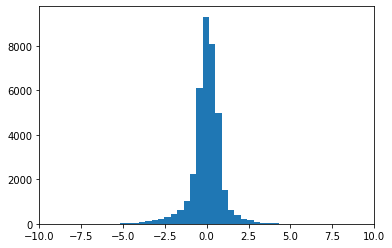

<IPython.core.display.Javascript object>

In [27]:
fig, ax = plt.subplots()
ax.hist(pred_test - y_test, bins=80)
ax.set_xlim(-10, 10)

In [38]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test, y_test)

<IPython.core.display.Javascript object>

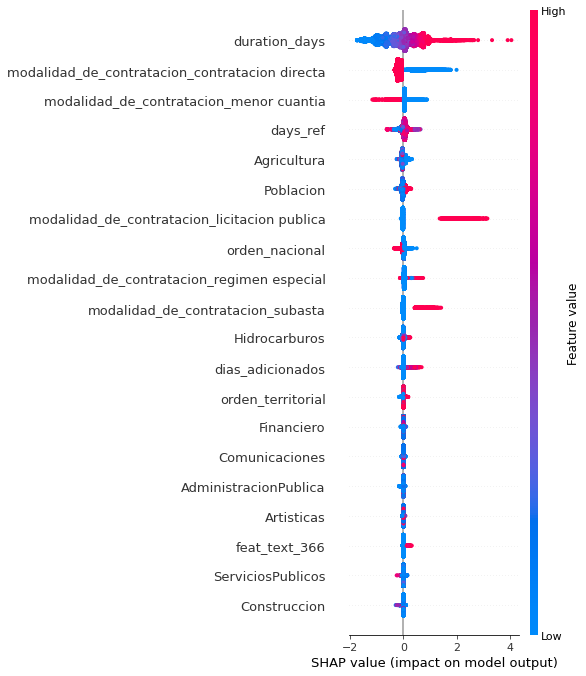

<IPython.core.display.Javascript object>

In [41]:
shap.summary_plot(shap_values, test)

## Deep neural network

In [8]:
inputs = keras.layers.Input([len(train.columns)], dtype=tf.float32)
x = keras.layers.Dense(250, activation="relu")(inputs)
x = keras.layers.Dropout(0.4)(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(100, activation="relu")(x)
x = keras.layers.Dropout(0.1)(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(50, activation="relu")(x)
x = keras.layers.Dropout(0.1)(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(20, activation="relu")(x)
x = keras.layers.Dropout(0.1)(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(10, activation="relu")(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

<IPython.core.display.Javascript object>

In [9]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 427)]             0         
                                                                 
 dense_6 (Dense)             (None, 250)               107000    
                                                                 
 dropout_4 (Dropout)         (None, 250)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 250)              1000      
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 100)               25100     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                           

<IPython.core.display.Javascript object>

In [10]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.RootMeanSquaredError()],
)

<IPython.core.display.Javascript object>

In [11]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=25, restore_best_weights=True
)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "../../data/06_models/dnn", save_best_only=True, monitor="val_loss", verbose=False
)

<IPython.core.display.Javascript object>

In [12]:
fit_history = model.fit(
    x=train.values,
    y=y_train,
    validation_data=(cv.values, y_cv),
    epochs=500,
    callbacks=[early_stopping, model_checkpoint],
    batch_size=500000,
)

Epoch 1/500


2022-08-14 21:33:57.906383: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-14 21:33:58.462298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 267.2365 - root_mean_squared_error: 16.3474

2022-08-14 21:34:03.967265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 8s 4s/step - loss: 267.2365 - root_mean_squared_error: 16.3474 - val_loss: 323.3218 - val_root_mean_squared_error: 17.9812
Epoch 2/500
2/2 [==============================] - 5s 3s/step - loss: 258.3819 - root_mean_squared_error: 16.0743 - val_loss: 286.0551 - val_root_mean_squared_error: 16.9132
Epoch 3/500
2/2 [==============================] - 5s 3s/step - loss: 251.8279 - root_mean_squared_error: 15.8691 - val_loss: 252.0323 - val_root_mean_squared_error: 15.8755
Epoch 4/500
2/2 [==============================] - 4s 3s/step - loss: 246.5735 - root_mean_squared_error: 15.7027 - val_loss: 222.5473 - val_root_mean_squared_error: 14.9180
Epoch 5/500
2/2 [==============================] - 4s 3s/step - loss: 241.7211 - root_mean_squared_error: 15.5474 - val_loss: 195.8120 - val_root_mean_squared_error: 13.9933
Epoch 6/500
2/2 [==============================] - 5s 3s/step - loss: 237.2363 - root_mean_squared_error: 15.4025 - val_loss: 174.1099 - val_r

Epoch 48/500
2/2 [==============================] - 5s 3s/step - loss: 120.3449 - root_mean_squared_error: 10.9702 - val_loss: 131.2733 - val_root_mean_squared_error: 11.4575
Epoch 49/500
2/2 [==============================] - 4s 3s/step - loss: 117.7706 - root_mean_squared_error: 10.8522 - val_loss: 128.5400 - val_root_mean_squared_error: 11.3375
Epoch 50/500
2/2 [==============================] - 5s 3s/step - loss: 115.2281 - root_mean_squared_error: 10.7344 - val_loss: 125.8958 - val_root_mean_squared_error: 11.2203
Epoch 51/500
2/2 [==============================] - 4s 3s/step - loss: 112.6856 - root_mean_squared_error: 10.6153 - val_loss: 123.3460 - val_root_mean_squared_error: 11.1061
Epoch 52/500
2/2 [==============================] - 4s 3s/step - loss: 110.2495 - root_mean_squared_error: 10.5000 - val_loss: 120.6990 - val_root_mean_squared_error: 10.9863
Epoch 53/500
2/2 [==============================] - 5s 3s/step - loss: 107.7953 - root_mean_squared_error: 10.3825 - val_loss

Epoch 96/500
2/2 [==============================] - 4s 3s/step - loss: 27.4724 - root_mean_squared_error: 5.2414 - val_loss: 32.7521 - val_root_mean_squared_error: 5.7229
Epoch 97/500
2/2 [==============================] - 4s 3s/step - loss: 26.2532 - root_mean_squared_error: 5.1238 - val_loss: 31.4260 - val_root_mean_squared_error: 5.6059
Epoch 98/500
2/2 [==============================] - 4s 3s/step - loss: 25.2002 - root_mean_squared_error: 5.0200 - val_loss: 30.4218 - val_root_mean_squared_error: 5.5156
Epoch 99/500
2/2 [==============================] - 4s 3s/step - loss: 24.9789 - root_mean_squared_error: 4.9979 - val_loss: 29.7317 - val_root_mean_squared_error: 5.4527
Epoch 100/500
2/2 [==============================] - 4s 3s/step - loss: 23.9605 - root_mean_squared_error: 4.8949 - val_loss: 28.1311 - val_root_mean_squared_error: 5.3039
Epoch 101/500
2/2 [==============================] - 4s 3s/step - loss: 22.8368 - root_mean_squared_error: 4.7788 - val_loss: 27.1453 - val_root

Epoch 144/500
2/2 [==============================] - 3s 1s/step - loss: 7.5834 - root_mean_squared_error: 2.7538 - val_loss: 6.7997 - val_root_mean_squared_error: 2.6076
Epoch 145/500
2/2 [==============================] - 4s 3s/step - loss: 7.6107 - root_mean_squared_error: 2.7587 - val_loss: 6.7719 - val_root_mean_squared_error: 2.6023
Epoch 146/500
2/2 [==============================] - 4s 3s/step - loss: 7.6683 - root_mean_squared_error: 2.7692 - val_loss: 6.6938 - val_root_mean_squared_error: 2.5872
Epoch 147/500
2/2 [==============================] - 4s 3s/step - loss: 7.7670 - root_mean_squared_error: 2.7869 - val_loss: 6.6779 - val_root_mean_squared_error: 2.5842
Epoch 148/500
2/2 [==============================] - 3s 1s/step - loss: 7.5639 - root_mean_squared_error: 2.7503 - val_loss: 7.0494 - val_root_mean_squared_error: 2.6551
Epoch 149/500
2/2 [==============================] - 3s 1s/step - loss: 7.4753 - root_mean_squared_error: 2.7341 - val_loss: 7.2245 - val_root_mean_sq

2/2 [==============================] - 4s 3s/step - loss: 4.7055 - root_mean_squared_error: 2.1692 - val_loss: 3.4035 - val_root_mean_squared_error: 1.8449
Epoch 241/500
2/2 [==============================] - 4s 3s/step - loss: 4.6880 - root_mean_squared_error: 2.1652 - val_loss: 3.3861 - val_root_mean_squared_error: 1.8401
Epoch 242/500
2/2 [==============================] - 5s 3s/step - loss: 4.6783 - root_mean_squared_error: 2.1629 - val_loss: 3.3682 - val_root_mean_squared_error: 1.8353
Epoch 243/500
2/2 [==============================] - 4s 3s/step - loss: 4.6631 - root_mean_squared_error: 2.1594 - val_loss: 3.3450 - val_root_mean_squared_error: 1.8289
Epoch 244/500
2/2 [==============================] - 4s 3s/step - loss: 4.6426 - root_mean_squared_error: 2.1547 - val_loss: 3.3187 - val_root_mean_squared_error: 1.8217
Epoch 245/500
2/2 [==============================] - 4s 3s/step - loss: 4.6311 - root_mean_squared_error: 2.1520 - val_loss: 3.2912 - val_root_mean_squared_error: 1

2/2 [==============================] - 4s 3s/step - loss: 3.9922 - root_mean_squared_error: 1.9980 - val_loss: 2.0699 - val_root_mean_squared_error: 1.4387
Epoch 337/500
2/2 [==============================] - 4s 3s/step - loss: 3.9767 - root_mean_squared_error: 1.9942 - val_loss: 2.0673 - val_root_mean_squared_error: 1.4378
Epoch 338/500
2/2 [==============================] - 5s 3s/step - loss: 3.9756 - root_mean_squared_error: 1.9939 - val_loss: 2.0649 - val_root_mean_squared_error: 1.4370
Epoch 339/500
2/2 [==============================] - 4s 3s/step - loss: 3.9726 - root_mean_squared_error: 1.9931 - val_loss: 2.0447 - val_root_mean_squared_error: 1.4299
Epoch 340/500
2/2 [==============================] - 4s 3s/step - loss: 3.9570 - root_mean_squared_error: 1.9892 - val_loss: 1.9919 - val_root_mean_squared_error: 1.4114
Epoch 341/500
2/2 [==============================] - 3s 1s/step - loss: 3.9594 - root_mean_squared_error: 1.9898 - val_loss: 2.0145 - val_root_mean_squared_error: 1

2/2 [==============================] - 3s 1s/step - loss: 3.5528 - root_mean_squared_error: 1.8849 - val_loss: 1.7708 - val_root_mean_squared_error: 1.3307
Epoch 433/500
2/2 [==============================] - 3s 1s/step - loss: 3.5425 - root_mean_squared_error: 1.8822 - val_loss: 1.7631 - val_root_mean_squared_error: 1.3278
Epoch 434/500
2/2 [==============================] - 3s 1s/step - loss: 3.5531 - root_mean_squared_error: 1.8850 - val_loss: 1.7715 - val_root_mean_squared_error: 1.3310
Epoch 435/500
2/2 [==============================] - 3s 1s/step - loss: 3.5370 - root_mean_squared_error: 1.8807 - val_loss: 1.7946 - val_root_mean_squared_error: 1.3396
Epoch 436/500
2/2 [==============================] - 3s 1s/step - loss: 3.5216 - root_mean_squared_error: 1.8766 - val_loss: 1.8158 - val_root_mean_squared_error: 1.3475
Epoch 437/500
2/2 [==============================] - 3s 1s/step - loss: 3.5183 - root_mean_squared_error: 1.8757 - val_loss: 1.8347 - val_root_mean_squared_error: 1

<IPython.core.display.Javascript object>

[<matplotlib.lines.Line2D object at 0x8eaea47c0>]

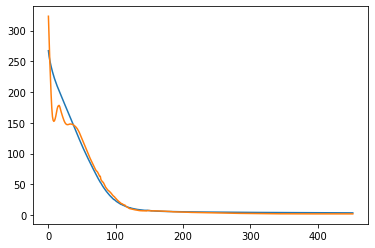

<IPython.core.display.Javascript object>

In [13]:
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])